Código disponível [na minha página do Github](https://github.com/arthurkenzo/atividades_ia525)

## Questão 1:
A problema de filtragem com regularização de Tikhonov é definido pela função objetivo

$$ \min_{u \in \mathbb{R}^n} \| u - x_c\|_2^2 + \delta \| Du \|_2^2. $$

Podemos reescrever uma soma de quadrados de normas $L_2$ em termos da norma de uma única matrix aumentada da seguinte forma:

$$ \| Au - B\|_2^2 + \| Cu - D\|_2^2 = \left\| {\begin{pmatrix} A \\ C \end{pmatrix}} u + {\begin{pmatrix} B \\ D \end{pmatrix}} \right\|_2^2 \quad \implies \quad \min_{u \in \mathbb{R}^n} \left\| {\begin{pmatrix} \mathbb{1} \\ \delta D \end{pmatrix}} u + {\begin{pmatrix} x_c \\ \mathbb{0} \end{pmatrix}} \right\|_2^2.$$

No caso da regularização de Tikhonov, temos $A = \mathbb{1}$, $B = x_c$, $C = \delta D$ e $D = 0$. Assim, podemos construir uma função objetivo equivalente àquela de um problema de mínimos quadrados. O problema obtido acima tem função objetivo quadrática e não tem restrições, sendo então convexo.

Para a regularização LASSO, é possível remodelar o termo em módulo da função objetivo por meio da adição de um termo linear na função objetivo e de restrições adicionais sobre o novo termo. Para uma variável real, temos:

$$ \begin{align*}
    \text{Minimize }    & | x | \\
\end{align*} \quad\implies\quad \begin{align*}
    \text{Minimize }    & t \\
    \text{ subject to } & -t \leq x \leq t \\
                        &  t \geq 0
\end{align*}  $$

Podemos então generalizar esse método para variáveis vetoriais, adicionando um vetor $t$ de dimensão igual a $u$ à função objetivo, junto com um conjunto de restrições $-t_i \leq d^\mathsf{T}_iu_i \leq t_i\, \forall i$, obtendo assim as formulações equivalentes:

$$ \begin{align*}
    \text{Minimize }    & \| u - x_c\|_2^2 + \delta \| Du \|_1 \\
\end{align*} \quad\implies\quad \begin{align*}
    \text{Minimize }    & \| u - x_c\|_2^2 + \delta \sum_i t_i \\
    \text{ subject to } & -t_i \leq d^\mathsf{T}_iu_i \leq t_i\quad \forall i \\
                        &  t \geq 0
\end{align*}  $$

Note que agora temos uma função objetivo quadrática, com restrições apenas lineares, o que torna deste um problema convexo tal qual a regularização de Tikhonov. 



## Implementações dos dois métodos de filtragem

In [165]:
import cvxpy as cp
import numpy as np
import mosek
import matplotlib.pyplot as plt
import time

from typing import Tuple

### Gerando amostragens de sinais para teste 

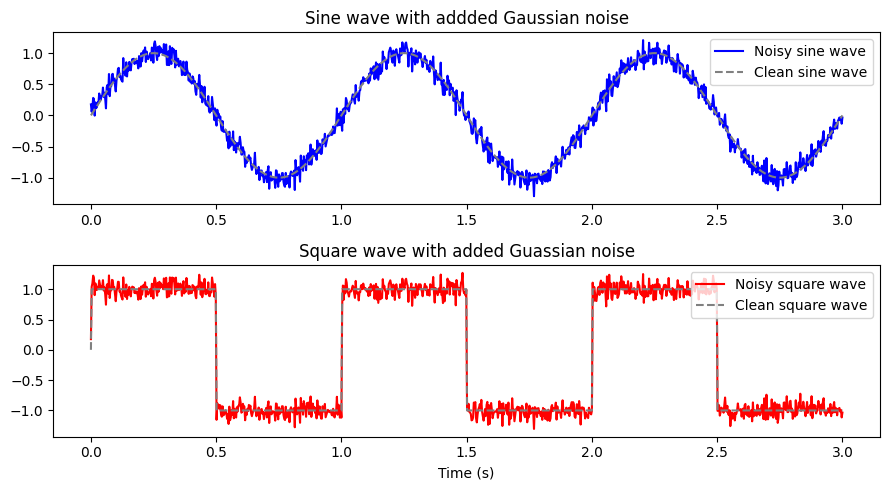

In [166]:
samples = 1000  # samples generated  
periods = 3     # wave parameters for signal generation 
frequency = 1     
amplitude = 1.0   
noiseStd = 0.1 # standard deviation for the gaussian noise  

# defining time steps 
t = np.linspace(0, periods / frequency, samples)

# generating signal arrays
sineWave = amplitude * np.sin(2 * np.pi * frequency * t)
squareWave = amplitude * np.sign(np.sin(2 * np.pi * frequency * t))

# generating noise array
np.random.seed(0) 
noise = np.random.normal(0, noiseStd, size=samples)

# adding noise to signals
noisySineWave = sineWave + noise
noisySquareWave = squareWave + noise

# Plotting
plt.figure(figsize=(9, 5))

plt.subplot(2, 1, 1)
plt.plot(t, noisySineWave, label="Noisy sine wave", color='blue')
plt.plot(t, sineWave, label="Clean sine wave", color='gray', linestyle='--')
plt.legend(loc= 'upper right')
plt.title("Sine wave with addded Gaussian noise")

plt.subplot(2, 1, 2)
plt.plot(t, noisySquareWave, label="Noisy square wave", color='red')
plt.plot(t, squareWave, label="Clean square wave", color='gray', linestyle='--')
plt.legend(loc= 'upper right')
plt.title("Square wave with added Guassian noise")

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

### Montagem dos programas quadráticos e funções auxiliares

In [167]:
def BuildDifferencesMatrix(n:int) -> np.ndarray: 
    """ Builds a centered difference matrix of size 'n' 

    Args:
        n (int): Size of the matrix

    Returns:
        np.ndarray: Difference matrix
    """
    diagonal = 2 * np.ones(n)
    offDiagonal = -1 * np.ones(n - 1)

    return np.diag(diagonal) + np.diag(offDiagonal, k=1) + np.diag(offDiagonal, k=-1)


def TikhonovFilter(noisySignal:np.ndarray, delta:float) -> Tuple[np.ndarray, float]:
    """ From a noisy signal sample and a penalization coefficient, return the filtered signal using Tikhonov regularization 

    Args:
        noisySignal (np.ndarray): noisy signal array
        delta (float): penalty coefficient

    Returns:
        Tuple[np.ndarray, float]: The filtered signal array and the optimal value for the objective function
    """

    samples = len(noisySignal)

    # building all necessary matrices for the least squares objective
    diffMatrix = BuildDifferencesMatrix(samples)
    idMatrix = np.eye(samples)
    zeros = np.zeros((samples))

    # building the quadratic program and solving it
    u = cp.Variable(samples)
    A = np.vstack((idMatrix, delta*diffMatrix))
    B = np.vstack((noisySignal, zeros))

    objective = cp.Minimize(cp.sum_squares(np.vstack((idMatrix, delta*diffMatrix)) @ u - np.concatenate((noisySignal, zeros))))
    problem = cp.Problem(objective)
    problem.solve(solver="MOSEK", verbose=False)

    return u.value, problem.value


def LassoFilter(noisySignal:np.ndarray, delta:float) -> Tuple[np.ndarray, float]:
    """ From a noisy signal sample and a penalization coefficient, return the filtered signal using Lasso regularization 

    Args:
        noisySignal (np.ndarray): noisy signal array
        delta (float): penalty coefficient

    Returns:
        Tuple[np.ndarray, float]: The filtered signal array and the optimal value for the objective function
    """

    samples = len(noisySignal)

    # building all necessary matrices for the least squares objective
    diffMatrix = BuildDifferencesMatrix(samples)
    idMatrix = np.eye(samples)
    zeros = np.zeros((samples))

    # building the quadratic program and solving it
    u = cp.Variable(samples)
    t = cp.Variable(samples)
    A = np.vstack((idMatrix, delta*diffMatrix))
    B = np.vstack((noisySignal, zeros))

    objective = cp.Minimize(cp.sum_squares(u - noisySignal) + delta*cp.sum(t))

    constraints = [-t <= diffMatrix @ u]
    constraints += [t >= diffMatrix @ u]
    constraints += [t >= np.zeros(samples)]

    quadraticProgram = cp.Problem(objective, constraints)
    quadraticProgram.solve(solver="MOSEK", verbose=False)


    return u.value, quadraticProgram.value



### Filtragem dos sinais de teste e resultados

In [168]:
tikhonovFilteredSine, _   = TikhonovFilter(noisySignal=noisySineWave, delta=10)
tikhonovFilteredSquare, _ = TikhonovFilter(noisySignal=noisySquareWave, delta=10)

lassoFilteredSine, _   = LassoFilter(noisySignal=noisySineWave, delta=10)
lassoFilteredSquare, _ = LassoFilter(noisySignal=noisySquareWave, delta=10)


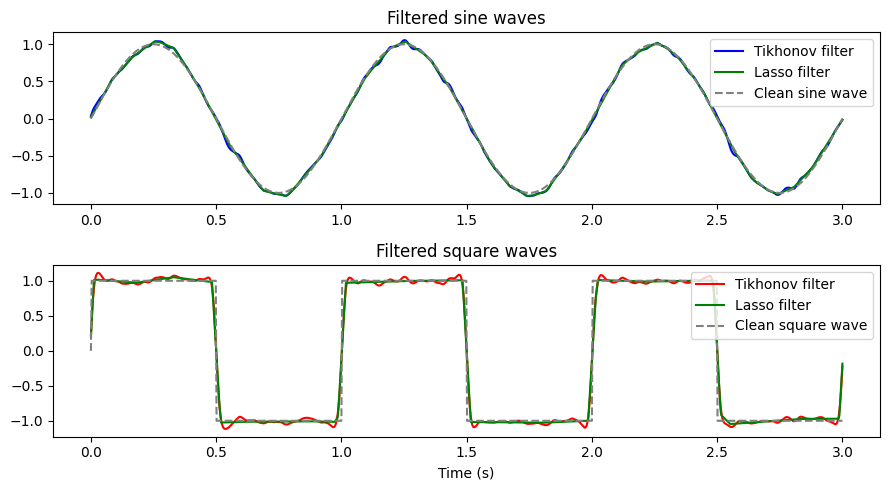

In [169]:
# Plotting
plt.figure(figsize=(9, 5))

plt.subplot(2, 1, 1)
plt.plot(t, tikhonovFilteredSine, label="Tikhonov filter", color='blue')
plt.plot(t, lassoFilteredSine, label="Lasso filter", color='green')

plt.plot(t, sineWave, label="Clean sine wave", color='gray', linestyle='--')
plt.legend(loc= 'upper right')
plt.title("Filtered sine waves")

plt.subplot(2, 1, 2)
plt.plot(t, tikhonovFilteredSquare, label="Tikhonov filter", color='red')
plt.plot(t, lassoFilteredSquare, label="Lasso filter", color='green')

plt.plot(t, squareWave, label="Clean square wave", color='gray', linestyle='--')
plt.legend(loc= 'upper right')
plt.title("Filtered square waves")

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

## Brevemente estudando o impacto do coeficiente de penalidade nas soluções:

In [170]:
startingPoint = 1
step = 5
points = 20
penalties = np.arange(startingPoint, startingPoint + step * points, step)

tikhonovOptimi = np.zeros(points)
lassoOptimi = np.zeros(points)
tikhonovDiff = np.zeros(points)
lassoDiff = np.zeros(points)

for i in range(points):
    tikhonovFilteredSignal, tikhonovOptimum = TikhonovFilter(noisySignal=noisySineWave, delta=penalties[i])
    lassoFilteredSignal, lassoOptimum = LassoFilter(noisySignal=noisySineWave, delta=penalties[i])
    tikhonovOptimi[i] = tikhonovOptimum
    lassoOptimi[i] = lassoOptimum
    tikhonovDiff[i] = np.linalg.norm(tikhonovFilteredSignal - sineWave)
    lassoDiff[i] = np.linalg.norm(lassoFilteredSignal - sineWave)


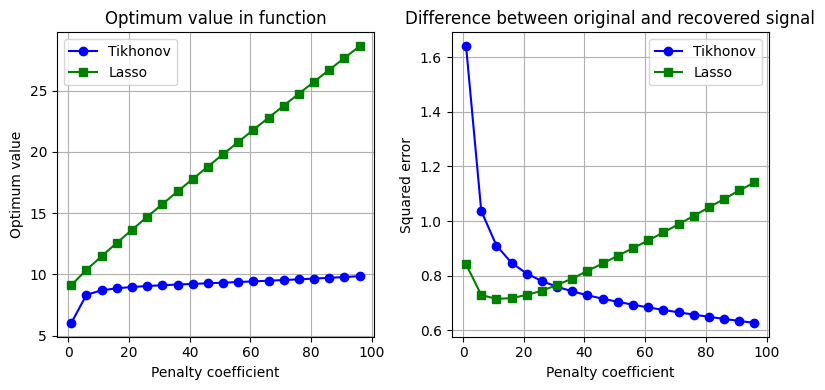

In [171]:
# Create 1 row, 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Width is doubled

# First plot
axs[0].plot(penalties, tikhonovOptimi, label="Tikhonov", marker='o', color='blue')
axs[0].plot(penalties, lassoOptimi, label="Lasso", marker='s', color='green')
axs[0].set_title("Optimum value in function")
axs[0].set_xlabel("Penalty coefficient")
axs[0].set_ylabel("Optimum value")
axs[0].legend()
axs[0].grid(True)

# Second plot
axs[1].plot(penalties, tikhonovDiff, label="Tikhonov", marker='o', color='blue')
axs[1].plot(penalties, lassoDiff, label="Lasso", marker='s', color='green')
axs[1].set_title("Difference between original and recovered signal")
axs[1].set_xlabel("Penalty coefficient")
axs[1].set_ylabel("Squared error")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Vemos do primeiro gráfico que, a menos de penalidades realmente muito elevadas (da ordem de $10^3$), os termos de regressão Lasso contribuem consideravelmente mais para o valor da função objetivo final, em comparação à regressão Tikhonov. No entanto se continuarmos a aumentar o valor de $\delta$, esperamos eventualmente chegar em uma situação onde os erros quadráticos do método de Tikhonov passem a ser maiores que os erros lineares da regressão Lasso. 

O segundo gráfico traz informações mais interessantes, pois nos mostra o valor ótimo para o coeficiente de penalidade $\delta$. Para a regressão Lasso, este valor se encontra entre $10$ e $20$. Para a regressão de Tikhonov, este valor se encontra na ordem de $10^2$, não sendo visível no gráfico produzido (mas observado em experimentos feitos com conjuntos de $\delta$ mais elevados). 

Podemos interpretar esse comportamento como o modelo tentando ao máximo minimizar as diferenças entre duas amostras consecutivas do sinal, devido ao peso desproporcional dado para o termo de penalidade $\| Du \|_1$ ou $\| Du \|_2^2$. Isso leva a um sinal filtrado se aproximando cada vez mais de uma constante a medida que $\delta$ aumenta, aumentando o erro entre o sinal original e o filtrado. Em um regime de $\delta$ pequeno no entanto, o aumento da penalidade implica em uma redução no erro do sinal filtrado, pois apenas componentes de frequência muita alta estão sendo filtradas (correspondentes ao ruído gaussiano), não afetando as componentes vindas do sinal original.

In [172]:
tikhonovFilteredSine, _   = TikhonovFilter(noisySignal=noisySineWave, delta=5000)
tikhonovFilteredSquare, _ = TikhonovFilter(noisySignal=noisySquareWave, delta=5000)

lassoFilteredSine, _   = LassoFilter(noisySignal=noisySineWave, delta=3000)
lassoFilteredSquare, _ = LassoFilter(noisySignal=noisySquareWave, delta=3000)


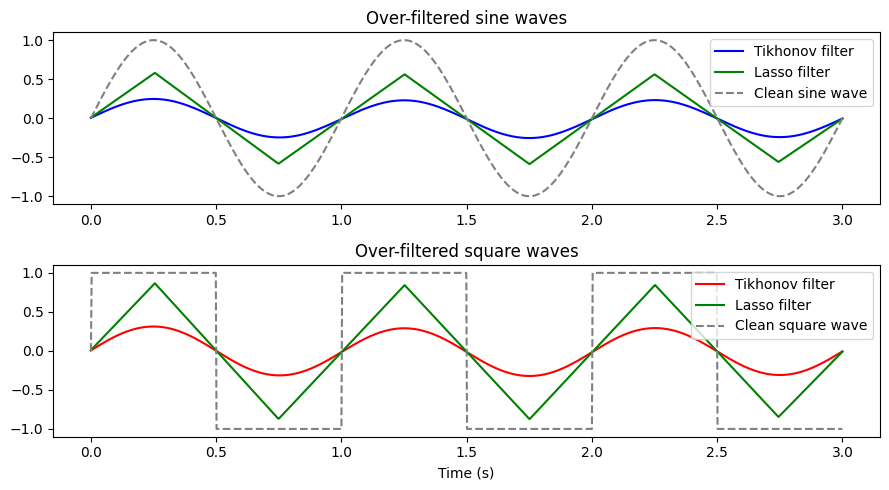

In [173]:
# Plotting
plt.figure(figsize=(9, 5))

plt.subplot(2, 1, 1)
plt.plot(t, tikhonovFilteredSine, label="Tikhonov filter", color='blue')
plt.plot(t, lassoFilteredSine, label="Lasso filter", color='green')

plt.plot(t, sineWave, label="Clean sine wave", color='gray', linestyle='--')
plt.legend(loc= 'upper right')
plt.title("Over-filtered sine waves")

plt.subplot(2, 1, 2)
plt.plot(t, tikhonovFilteredSquare, label="Tikhonov filter", color='red')
plt.plot(t, lassoFilteredSquare, label="Lasso filter", color='green')

plt.plot(t, squareWave, label="Clean square wave", color='gray', linestyle='--')
plt.legend(loc= 'upper right')
plt.title("Over-filtered square waves")

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

Aqui ilustramos os efeitos de penalidades extremamente altas a ponto de distorcer completamente o sinal obtido na saída do filtro. Em ambos os casos, vemos a tendẽncia dos filtros de atenuarem o sinal até que, no limite de $\delta \to \infty$, a saída é constante no tempo. No entanto, é possível ver que o filtro Lasso tem a tendência a gerar ondas triangulares, enquanto os sinais atenuados do filtro de Tikhonov se aproximam de ondas senoidais. Isso com certeza é consequência da norma utilizada em cada um $L^1$ vs. $L^2$, porém não saberia desenvolver muito mais a intuição geométrica por trás disso (além do fato de que bolas abertas com $L^1$ são mais "quadradas" que bolas abertas em $L^2$). 